In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import scipy.signal as signal
from scipy.stats import pearsonr,zscore


sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk")

In [3]:
from lab.classes import pcExperimentGroup
import lab.classes.database as db
import lab.analysis.behavior_analysis as ba
import lab.analysis.new_intervals as ni

In [4]:

def pupil_size(path,plot=False):
    """
    Given DLC model out data, return distance between top/bottom and 
    left/right pupil points.
    """
    df = pd.read_hdf(path)
    t=df.columns[0][0] # name of training snapshot, hopefully only 1 
    
    # calculate vertical dist
    top = np.array(zip(df[t,'top','x'].values, df[t,'top','y'].values))
    bottom = np.array(zip(df[t,'bottom','x'].values, df[t,'bottom','y'].values))
    dvert = np.linalg.norm(top - bottom,axis=1)
    
    # calculate horizontal dist
    left = np.array(zip(df[t,'left','x'].values, df[t,'left','y'].values))
    right = np.array(zip(df[t,'right','x'].values, df[t,'right','y'].values))
    dhorz = np.linalg.norm(left - right,axis=1)
    
    if plot:
        plt.figure(figsize=(10,5))
        sns.lineplot(x=np.arange(0,len(dvert)),y=dvert)
        sns.lineplot(x=np.arange(0,len(dhorz)),y=dhorz)
    
    return dvert,dhorz

In [9]:
# useful line to find files with string
!cd ~/creb/CREB9/mjd536 && ls | grep RF

20180614-RF-MJD4B-DEEP-1
20180614-RF-MJD4B-DEEP-2
20180615-RF-burlap-DEEP-0
20180616-RF-MJD4B-SUP-1
20180616-RF-MJD4B-SUP-2
20180617-RF-MJD4B-DEEP-1
20180617-RF-MJD4B-DEEP-2
20180618-RF-MJD4-1-1-1
20180618-RF-MJD4-1-1-2
20180618-RF-MJD4-1-1-3
20180619-RF-MJD4-1-2-1
20180619-RF-MJD4-1-2-2
20180619-RF-MJD4-1-2-3
20180620-RF-MJD4-1-3-1
20180620-RF-MJD4-1-3-2
20180620-RF-MJD4-1-3-3
20180621-RF-MJD4-2-4-1


In [36]:
# useful line to find files with string
!cd ~/creb/pupil/CREB9/processed && ls | grep h5

mjd535_20180614121218DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd535_20180614151007DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd535_20180616163628DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd535_20180616190121DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd535_20180617121859DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd535_20180617145209DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd536_20180614125338DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd536_20180614160120DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd536_20180615123542DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd536_20180616133213DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd536_20180616152918DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd536_20180617124304DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd536_20180617152540DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd537_20180614132600DeepCut_resnet50_pupilMay11shuffle1_240000.h5
mjd537_20180614164610DeepCut_resnet50_pupilMay11shuffle1_24000

# define imaging experiments of interest

In [8]:
# get filenames 

m35 = ['/home/matt/creb/CREB9/mjd535/20180614-RF-MJD4B-DEEP-1',
       '/home/matt/creb/CREB9/mjd535/20180614-RF-MJD4B-DEEP-2',
       '/home/matt/creb/CREB9/mjd535/20180616-RF-MJD4B-SUP-1',
       '/home/matt/creb/CREB9/mjd535/20180616-RF-MJD4B-SUP-2',
       '/home/matt/creb/CREB9/mjd535/20180617-RF-MJD4B-DEEP-1',
       '/home/matt/creb/CREB9/mjd535/20180617-RF-MJD4B-DEEP-2']

m36 = ["/home/matt/creb/CREB9/mjd536/20180614-RF-MJD4B-DEEP-1",
       "/home/matt/creb/CREB9/mjd536/20180614-RF-MJD4B-DEEP-2",
       "/home/matt/creb/CREB9/mjd536/20180616-RF-MJD4B-SUP-1",
       "/home/matt/creb/CREB9/mjd536/20180616-RF-MJD4B-SUP-2",
       "/home/matt/creb/CREB9/mjd536/20180617-RF-MJD4B-DEEP-1",
       "/home/matt/creb/CREB9/mjd536/20180617-RF-MJD4B-DEEP-2"]


m37 = ["/home/matt/creb/CREB9/mjd537/20180614-RF-MJD4B-DEEP-1",
       "/home/matt/creb/CREB9/mjd537/20180614-RF-MJD4B-DEEP-2",
       "/home/matt/creb/CREB9/mjd537/20180616-RF-MJD4B-SUP-1",
       "/home/matt/creb/CREB9/mjd537/20180616-RF-MJD4B-SUP-2",
       "/home/matt/creb/CREB9/mjd537/20180617-RF-MJD4B-DEEP-1",
       "/home/matt/creb/CREB9/mjd537/20180617-RF-MJD4B-DEEP-2"]

expt_files = m35  + m37

p35 = ["mjd535_20180614121218DeepCut_resnet50_pupilMay11shuffle1_240000.h5",
"mjd535_20180614151007DeepCut_resnet50_pupilMay11shuffle1_240000.h5",
"mjd535_20180616163628DeepCut_resnet50_pupilMay11shuffle1_240000.h5",
"mjd535_20180616190121DeepCut_resnet50_pupilMay11shuffle1_240000.h5",
"mjd535_20180617121859DeepCut_resnet50_pupilMay11shuffle1_240000.h5",
"mjd535_20180617145209DeepCut_resnet50_pupilMay11shuffle1_240000.h5"]

p37=[]

pupil_files = p35 + p37

In [10]:
# make experiement list, extract useful data
expt_list=[]
for ef in expt_files:
    expt=db.createExperiment(tSeries_path=ef)
    trial = expt[0]
    bd = trial.behaviorData()
    expt_list.append(expt)
    print(expt.get('tSeriesDirectory'),expt.get('trial_id'),ba.lickCount(trial),len(bd['lap']))

('/home/matt/creb/CREB9/mjd535/20180614-RF-MJD4B-DEEP-1', '13145', 1702, 8)
('/home/matt/creb/CREB9/mjd535/20180614-RF-MJD4B-DEEP-2', '13144', 1060, 4)
('/home/matt/creb/CREB9/mjd535/20180616-RF-MJD4B-SUP-1', '13139', 1936, 10)
('/home/matt/creb/CREB9/mjd535/20180616-RF-MJD4B-SUP-2', '13143', 2603, 17)
('/home/matt/creb/CREB9/mjd535/20180617-RF-MJD4B-DEEP-1', '13172', 1544, 10)
('/home/matt/creb/CREB9/mjd535/20180617-RF-MJD4B-DEEP-2', '13173', 1483, 10)
('/home/matt/creb/CREB9/mjd537/20180614-RF-MJD4B-DEEP-1', '13167', 1991, 10)
('/home/matt/creb/CREB9/mjd537/20180614-RF-MJD4B-DEEP-2', '13165', 2851, 12)
('/home/matt/creb/CREB9/mjd537/20180616-RF-MJD4B-SUP-1', '13169', 3517, 16)
('/home/matt/creb/CREB9/mjd537/20180616-RF-MJD4B-SUP-2', '13168', 3613, 21)
('/home/matt/creb/CREB9/mjd537/20180617-RF-MJD4B-DEEP-1', '13176', 2633, 17)
('/home/matt/creb/CREB9/mjd537/20180617-RF-MJD4B-DEEP-2', '13177', 2463, 18)


In [11]:
# put in group
pc_kwargs = {'nPositionBins': 100,'channel': 'Ch2','imaging_label': 'suite2p','demixed': False}        
expt_grp = pcExperimentGroup(expt_list, label='pupil', **pc_kwargs)

In [12]:
run = ni.running_intervals(expt_grp)
run = run.resample(inplace=False).fillna({'start': 0, 'stop': 720})
run['duration'] = run['stop'] - run['start']
run.groupby("trial").sum()

start      stop  duration
trial                              
[]     12448.82  12793.74    344.92
[]     12990.69  13327.33    336.64
[]      5050.51   5235.59    185.08
[]     15115.44  15504.72    389.28
[]     16564.46  16993.23    428.77
[]     23861.89  24354.84    492.95
[]     17631.74  17997.60    365.86
[]     17675.67  18166.53    490.86
[]     14276.70  14602.71    326.01
[]     16649.99  17049.99    400.00
[]     10074.82  10353.29    278.47
[]     16943.49  17361.79    418.30

In [13]:
# stationary 
stat = ni.stationary_intervals(expt_grp)

# resample and sum by trial
stat = stat.resample(inplace=False).fillna({'start': 0, 'stop': 720})
stat['duration'] = stat.stop - stat.start


# breakout + pd.dataframe
stat_df = pd.DataFrame(stat)
stat_df["trial_id"] = stat_df.trial.apply(lambda x: x.parent.trial_id)

stat_df.groupby("trial_id").sum()

start      stop  duration
trial_id                              
13139     17997.60  18351.74    354.14
13143     18166.53  18395.67    229.14
13144      5235.59   5770.51    534.92
13145     12793.74  13168.82    375.08
13165     15504.72  15835.44    330.72
13167     13327.33  13710.69    383.36
13168     24354.84  24581.89    227.05
13169     16993.23  17284.46    291.23
13172     14602.71  14996.70    393.99
13173     10353.29  10794.82    441.53
13176     17049.99  17369.99    320.00
13177     17361.79  17663.49    301.70

In [14]:
stat_sync=stat.resample(new_sampling_interval=1/7.8125)
stat_sync.start = stat_sync.start.astype("int")
stat_sync.stop = stat_sync.stop.astype("int")
stat_sync = pd.DataFrame(stat_sync)

## plot intervals

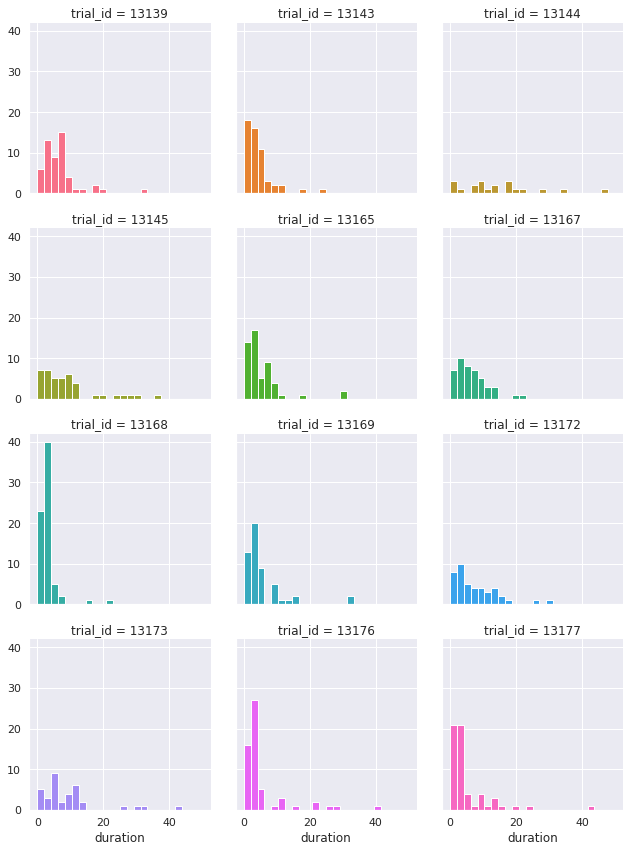

In [166]:
# stationary lengths
g = sns.FacetGrid(stat_df, col="trial_id",col_wrap=3, hue="trial_id", margin_titles=True)
bins = np.linspace(0, 50, 25)
g.map(plt.hist,"duration",bins=bins)

# ca + pupil single

In [23]:
def get_pupil_and_ca(pfn,efn):
    """Given SIMA tseries and DLC pupil h5 file, return mean_ca and pupil diameter"""
    # load pupil
    dvert, dhorz = pupil_size(pfn,plot=False)

    # load expt
    expt=db.createExperiment(tSeries_path=efn)
    numberBehaviorFrames= expt.num_frames()

    # resample pupil data to behavior
    rs_dvert = signal.resample(dvert, numberBehaviorFrames)


    mean_ca=np.nanmean(expt.imagingData(dFOverF='from_file'),axis=0)


    # rew/unrew ints
    rew_ints, unrew_ints = ba.calculateRewardedLickIntervals(expt,imageSync=True)

    rew_df = pd.DataFrame(rew_ints[0],columns=["start","stop"])
    
    return rs_dvert,mean_ca

In [26]:
#13167
pfn='/home/matt/creb/pupil/CREB9/processed/mjd537_20180614132600DeepCut_resnet50_pupilMay11shuffle1_240000.h5'
efn='/home/matt/creb/CREB9/mjd537/20180614-RF-MJD4B-DEEP-1'


rs_dvert,mean_ca = get_pupil_and_ca(pfn,efn)

# select single from experimentGroup output (above)
stat_x = stat_sync.query("trial_id==13167").reset_index()


zp = zscore(rs_dvert)
zc = zscore(mean_ca)

In [208]:
stat_df.query("trial_id==13167").reset_index()
stat_x = stat_sync.query("trial_id==13167").reset_index()

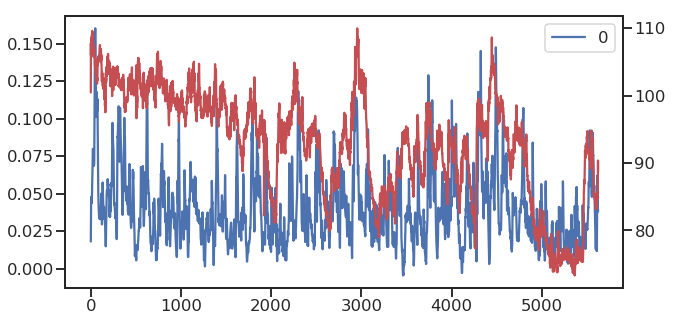

In [174]:
%matplotlib inline

# check pupil
plt.figure(figsize=(10,5))
sns.lineplot(data=mean_ca)
ax2 = plt.twinx()
sns.lineplot(data=rs_dvert,color='r',ax=ax2)
#sns.lineplot(data=velo,color='g',ax=ax2)

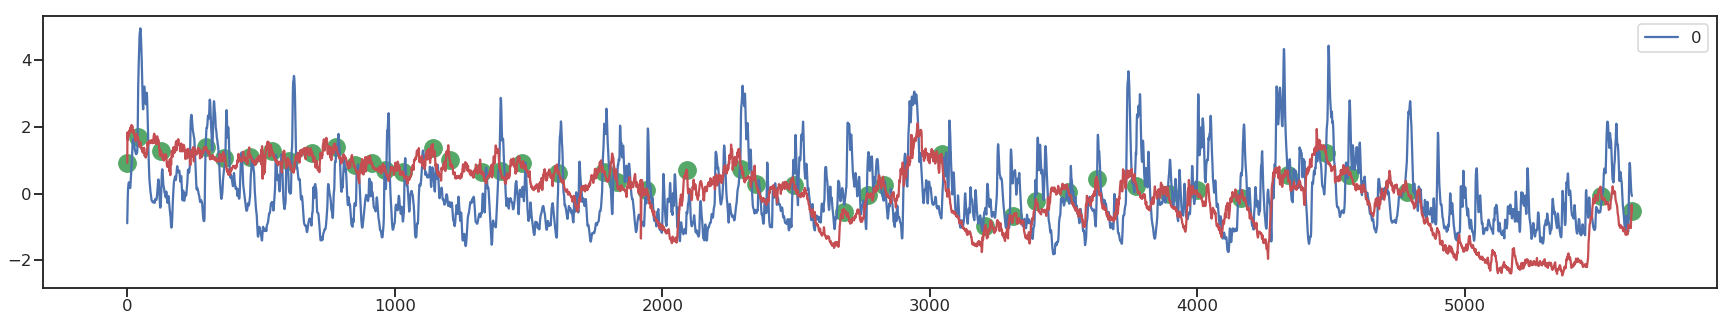

In [214]:
# zscore start stationary
plt.figure(figsize=(30,5))
sns.lineplot(data=zc)
sns.lineplot(data=zp,color='r')

plt.scatter(stat_x.start,zp[stat_x.start],s=300,c='g',marker='o')


### stationary intervals on pupil trace (zcored)

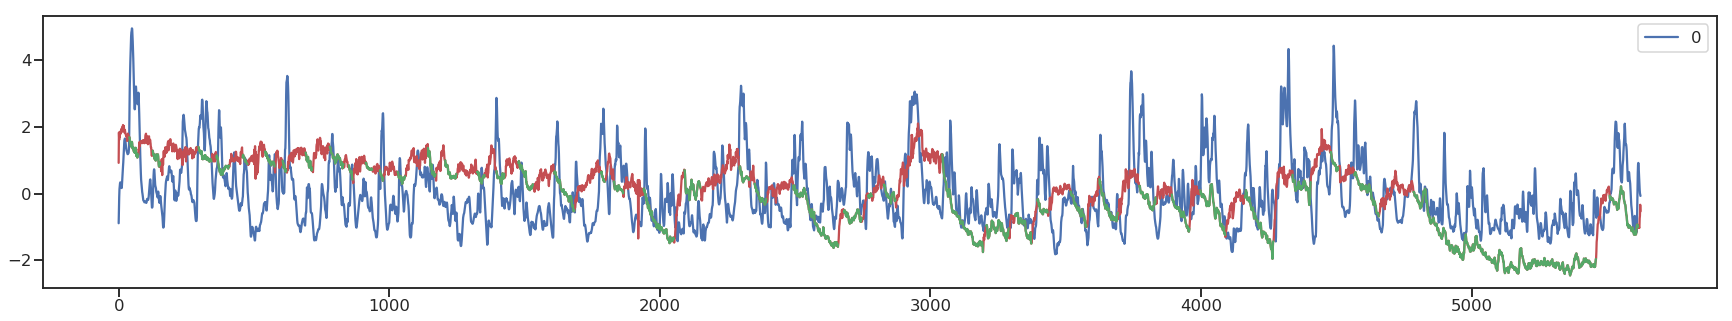

In [240]:
plt.figure(figsize=(30,5))
sns.lineplot(data=zc)
sns.lineplot(data=zp,color='r')

for _,row in stat_x.iterrows():
    plt.plot(np.arange(row.start,row.stop),zp[row.start:row.stop],'g')

(4800, 5500)

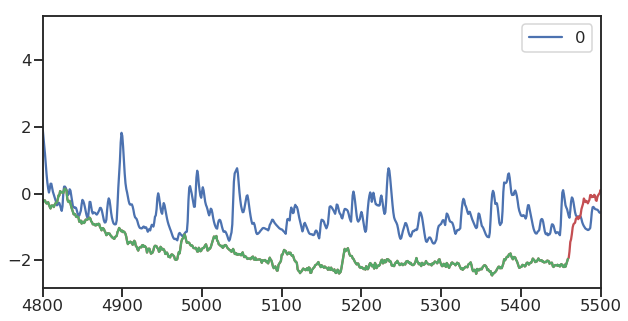

In [32]:
plt.figure(figsize=(10,5))
sns.lineplot(data=zc)
sns.lineplot(data=zp,color='r')


for _,row in stat_x.iterrows():
    plt.plot(np.arange(row.start,row.stop),zp[row.start:row.stop],'g')

plt.xlim(4800,5500)    


### reward intervals on pupil trace

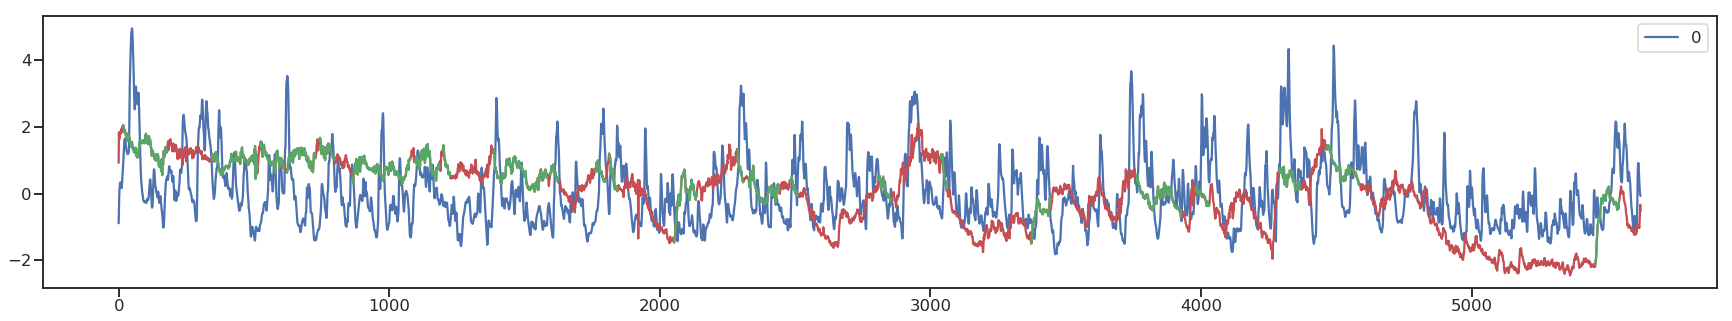

In [236]:
plt.figure(figsize=(30,5))
sns.lineplot(data=zc)
sns.lineplot(data=zp,color='r')

for _,row in rew_df.iterrows():
    plt.plot(np.arange(row.start,row.stop),zp[row.start:row.stop],'g')

# single 2

In [37]:
#13144
pfn='/home/matt/creb/pupil/CREB9/processed/mjd535_20180614151007DeepCut_resnet50_pupilMay11shuffle1_240000.h5'
efn='/home/matt/creb/CREB9/mjd535/20180614-RF-MJD4B-DEEP-2'


rs_dvert,mean_ca = get_pupil_and_ca(pfn,efn)

# select single from experimentGroup output (above)
stat_x = stat_sync.query("trial_id==13144").reset_index()


zp = zscore(rs_dvert)
zc = zscore(mean_ca)

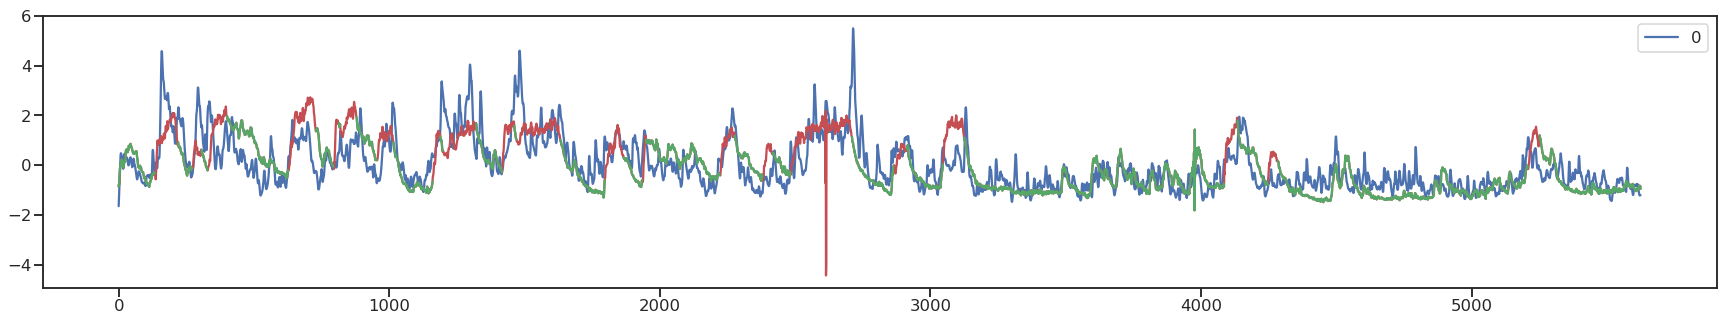

In [38]:
plt.figure(figsize=(30,5))
sns.lineplot(data=zc)
sns.lineplot(data=zp,color='r')

for _,row in stat_x.iterrows():
    plt.plot(np.arange(row.start,row.stop),zp[row.start:row.stop],'g')

(3200, 4200)

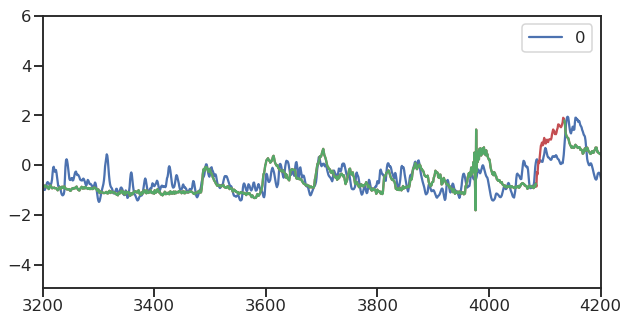

In [39]:
plt.figure(figsize=(10,5))
sns.lineplot(data=zc)
sns.lineplot(data=zp,color='r')


for _,row in stat_x.iterrows():
    plt.plot(np.arange(row.start,row.stop),zp[row.start:row.stop],'g')

plt.xlim(3200,4200)    


# single 3 

In [41]:
#13167
pfn='/home/matt/creb/pupil/CREB9/processed/mjd535_20180614121218DeepCut_resnet50_pupilMay11shuffle1_240000.h5'
efn='/home/matt/creb/CREB9/mjd535/20180614-RF-MJD4B-DEEP-1'


rs_dvert,mean_ca = get_pupil_and_ca(pfn,efn)

# select single from experimentGroup output (above)
stat_x = stat_sync.query("trial_id==13145").reset_index()


zp = zscore(rs_dvert)
zc = zscore(mean_ca)



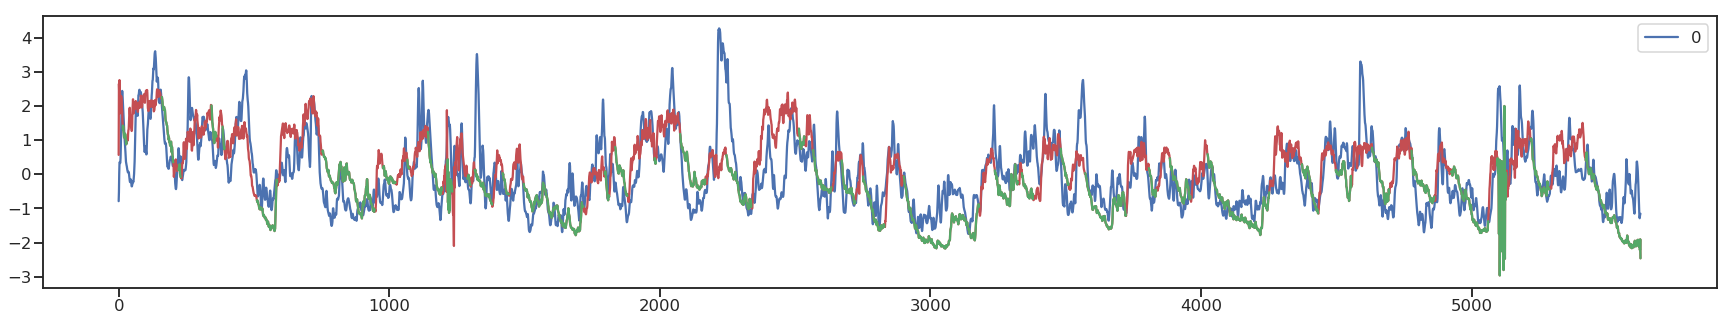

In [42]:
plt.figure(figsize=(30,5))
sns.lineplot(data=zc)
sns.lineplot(data=zp,color='r')

for _,row in stat_x.iterrows():
    plt.plot(np.arange(row.start,row.stop),zp[row.start:row.stop],'g')

# possible functions

expteriment.py: running runningIntervals velocity lickingIntervals rewardPositions lickCount absolutePosition
ba: calculateRewardedLickIntervals

exptGrp: lick_bount_duration: rew/unrew in seconds, number of laps, numbe_of_licks,behavior_dataframe,stim_position,velocity_dataframe


new intervals: running_intervals, stationary_intervals (seconds)

# auto matching - doesnt work rn

In [1]:
import glob
from pathlib import Path
from datetime import datetime

directory='/home/matt/creb/pupil/CREB9/processed'
files = glob.glob(directory + "/*.h5")


# get list of experiments to find
expt_list= [Path(x).name.split('Deep')[0] for x in files]
#expt_list= [Path(x).name.split('Deep')[0].split('_')[1] for x in files]

sorted_files = sorted(zip(expt_list,files))
sorted(expt_list)

['mjd535_20180614121218',
 'mjd535_20180614151007',
 'mjd535_20180616163628',
 'mjd535_20180616190121',
 'mjd535_20180617121859',
 'mjd535_20180617145209',
 'mjd536_20180614125338',
 'mjd536_20180614160120',
 'mjd536_20180615123542',
 'mjd536_20180616133213',
 'mjd536_20180616152918',
 'mjd536_20180617124304',
 'mjd536_20180617152540',
 'mjd537_20180614132600',
 'mjd537_20180614164610',
 'mjd537_20180615131409',
 'mjd537_20180616135719',
 'mjd537_20180616160106',
 'mjd537_20180617132111',
 'mjd537_20180617154756']

In [436]:
# pupil files to datetime
times = [datetime.strptime(x[0],'%Y%m%d%H%M%S') for x in sorted_files]

# single files to datetime
expt_time =datetime.strptime(expt.get('startTime'),'%Y-%m-%d-%Hh%Mm%Ss')
pupil_time = datetime.strptime('20180616163628','%Y%m%d%H%M%S')


# find nearest in a list of items
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

nearest(times,expt_time)

['mjd535_20180614121218',
 'mjd535_20180614151007',
 'mjd535_20180616163628',
 'mjd535_20180616190121',
 'mjd535_20180617121859',
 'mjd535_20180617145209',
 'mjd536_20180614125338',
 'mjd536_20180614160120',
 'mjd536_20180615123542',
 'mjd536_20180616133213',
 'mjd536_20180616152918',
 'mjd536_20180617124304',
 'mjd536_20180617152540',
 'mjd537_20180614132600',
 'mjd537_20180614164610',
 'mjd537_20180615131409',
 'mjd537_20180616135719',
 'mjd537_20180616160106',
 'mjd537_20180617132111',
 'mjd537_20180617154756']

# manual pupil file matching

In [448]:
pupil_files = [x[1] for i,x in enumerate(sorted_files) if i <6]
pupil_files

['/home/matt/creb/pupil/CREB9/processed/mjd535_20180614121218DeepCut_resnet50_pupilMay11shuffle1_240000.h5',
 '/home/matt/creb/pupil/CREB9/processed/mjd535_20180614151007DeepCut_resnet50_pupilMay11shuffle1_240000.h5',
 '/home/matt/creb/pupil/CREB9/processed/mjd535_20180616163628DeepCut_resnet50_pupilMay11shuffle1_240000.h5',
 '/home/matt/creb/pupil/CREB9/processed/mjd535_20180616190121DeepCut_resnet50_pupilMay11shuffle1_240000.h5',
 '/home/matt/creb/pupil/CREB9/processed/mjd535_20180617121859DeepCut_resnet50_pupilMay11shuffle1_240000.h5',
 '/home/matt/creb/pupil/CREB9/processed/mjd535_20180617145209DeepCut_resnet50_pupilMay11shuffle1_240000.h5']

# distance function for DLC

# load pupil data

In [ ]:
# could probably put resample directly to detect pupil phases
# need to cehck if I still like smoothing

In [ ]:
# non function version
pfn='/home/matt/creb/pupil/CREB9/processed/\
mjd535_20180616190121DeepCut_resnet50_pupilMay11shuffle1_240000.h5'
efn='/home/matt/creb/CREB9/mjd535/20180616-RF-MJD4B-SUP-2'

# load pupil
dvert, dhorz = pupil_size(pfn,plot=False)

# load expt
expt=db.createExperiment(tSeries_path=efn)
numberBehaviorFrames= expt.num_frames()

# resample pupil data to behavior
rs_dvert = signal.resample(dvert, numberBehaviorFrames)

# calculate pupil phases
d, df_pupil = pupil.detect_pupil_phases(dvert,seconds=False,
                                        plot_phases=True,cutoff_freq = .5)

# load trans
trans = expt.transientsData(label='suite2p', roi_filter=None,dataframe=True)
df_c = trans.groupby("start_frame").count().reset_index()
df_c = df_c.filter(["start_frame","duration"])

# ca mean
mean_ca=np.nanmean(expt.imagingData(dFOverF='from_file'),axis=0)


# resample pupil to beahvior drames
sampling_interval = 30/7.8125
df_pupil["start_rs"] = df_pupil.start.apply(lambda x: int(x/sampling_interval))
df_pupil["end_rs"] = df_pupil.end.apply(lambda x: int(x/sampling_interval))

# make dataframe where full indexes represented
df_pupil_full=pd.DataFrame(np.arange(0,numberBehaviorFrames))
df_pupil_full["event_type"] = ''
for ind,row in df_pupil.iterrows():
    if row.event_type == 'constriction':
        df_pupil_full.loc[row.start_rs:row.end_rs,"event_type"] = "constriction"
    if row.event_type == 'dilation':
        df_pupil_full.loc[row.start_rs:row.end_rs,"event_type"] = "dilation"

df_pupil_full.rename(columns={0:'index'},inplace = True)

# merge with imaging DF
df_merge = pd.merge(df_pupil_full,df_c,left_on="index",right_on = "start_frame",how="left")  


<IPython.core.display.Javascript object>


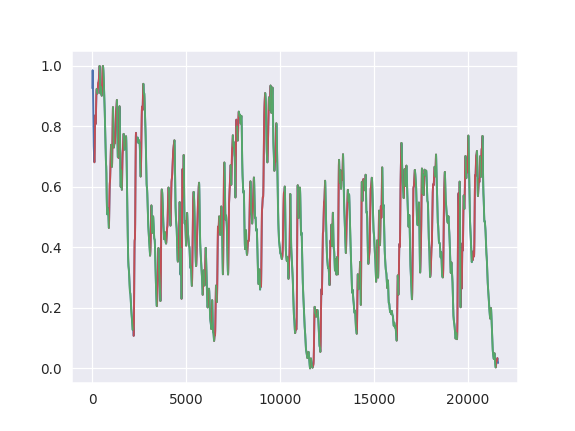

<IPython.core.display.Javascript object>


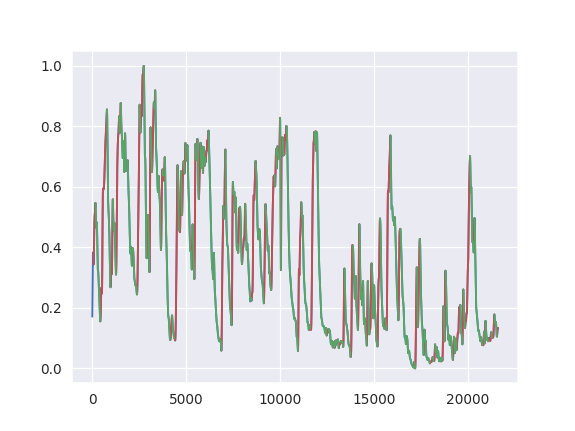

<IPython.core.display.Javascript object>


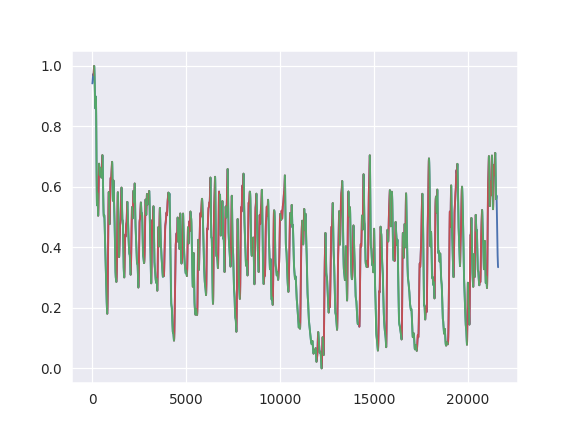

<IPython.core.display.Javascript object>


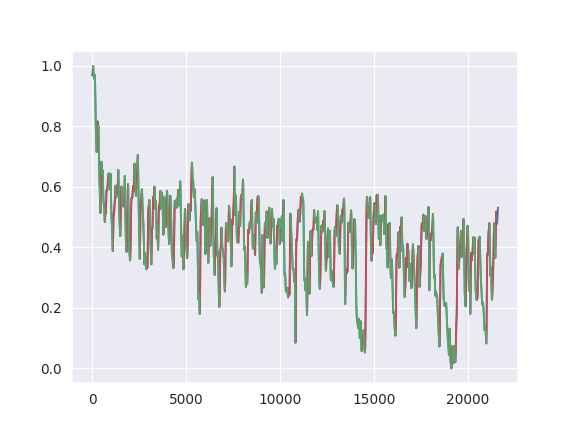

<IPython.core.display.Javascript object>


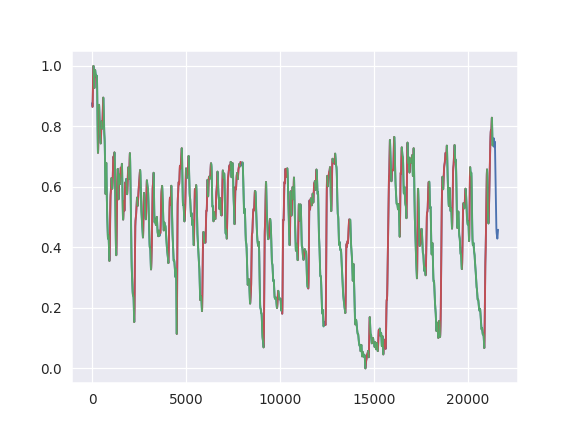

<IPython.core.display.Javascript object>


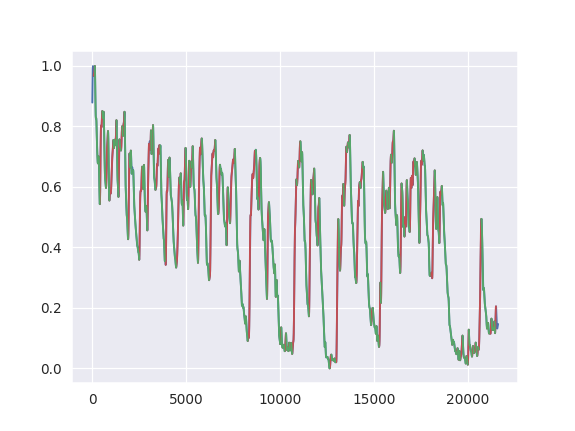

index event_type  start_frame  duration
0         0                     0.0      20.0
1         1                     1.0       1.0
2         2                     2.0       1.0
3         3                     3.0       1.0
4         4                     NaN       NaN
5         5                     5.0       2.0
6         6                     NaN       NaN
7         7                     7.0       2.0
8         8                     8.0       1.0
9         9                     9.0       3.0
10       10                    10.0       3.0
11       11                     NaN       NaN
12       12                     NaN       NaN
13       13                     NaN       NaN
14       14                     NaN       NaN
15       15                     NaN       NaN
16       16                     NaN       NaN
17       17                     NaN       NaN
18       18                    18.0       1.0
19       19                     NaN       NaN
20       20                     NaN       NaN
21       21                     NaN       NaN
22       22                    22.0       1.0
23       23                     NaN       NaN
24       24                     NaN       NaN
25       25                    25.0       1.0
26       26                    26.0       1.0
27       27                     NaN       NaN
28       28                     NaN       NaN
29       29   dilation          NaN       NaN
...     ...        ...          ...       ...
5595   5595   dilation          NaN       NaN
5596   5596                     NaN       NaN
5597   5597                     NaN       NaN
5598   5598                     NaN       NaN
5599   5599                     NaN       NaN
5600   5600                     NaN       NaN
5601   5601                  5601.0       1.0
5602   5602                     NaN       NaN
5603   5603                     NaN       NaN
5604   5604                     NaN       NaN
5605   5605                  5605.0       1.0
5606   5606                     NaN       NaN
5607   5607                  5607.0       1.0
5608   5608                     NaN       NaN
5609   5609                     NaN       NaN
5610   5610                     NaN       NaN
5611   5611                     NaN       NaN
5612   5612                     NaN       NaN
5613   5613                  5613.0       1.0
5614   5614                     NaN       NaN
5615   5615                     NaN       NaN
5616   5616                     NaN       NaN
5617   5617                  5617.0       1.0
5618   5618                     NaN       NaN
5619   5619                     NaN       NaN
5620   5620                     NaN       NaN
5621   5621                     NaN       NaN
5622   5622                     NaN       NaN
5623   5623                     NaN       NaN
5624   5624                     NaN       NaN

[33750 rows x 4 columns]

In [520]:



def transients_in_phase(pfn,efn):
    # load pupil
    dvert, dhorz = pupil_size(pfn,plot=False)

    # load expt
    expt=db.createExperiment(tSeries_path=efn)
    numberBehaviorFrames= expt.num_frames()

    # resample pupil data to behavior
    rs_dvert = signal.resample(dvert, numberBehaviorFrames)

    # calculate pupil phases
    d, df_pupil = pupil.detect_pupil_phases(dvert,seconds=False,
                                            plot_phases=True,cutoff_freq = .5)

    # load trans
    trans = expt.transientsData(label='suite2p', roi_filter=None,dataframe=True)
    df_c = trans.groupby("start_frame").count().reset_index()
    df_c = df_c.filter(["start_frame","duration"])

    # ca mean
    mean_ca=np.nanmean(expt.imagingData(dFOverF='from_file'),axis=0)


    # resample pupil to beahvior drames
    sampling_interval = 30/7.8125
    df_pupil["start_rs"] = df_pupil.start.apply(lambda x: int(x/sampling_interval))
    df_pupil["end_rs"] = df_pupil.end.apply(lambda x: int(x/sampling_interval))

    # make dataframe where full indexes represented
    df_pupil_full=pd.DataFrame(np.arange(0,numberBehaviorFrames))
    df_pupil_full["event_type"] = ''
    for ind,row in df_pupil.iterrows():
        if row.event_type == 'constriction':
            df_pupil_full.loc[row.start_rs:row.end_rs,"event_type"] = "constriction"
        if row.event_type == 'dilation':
            df_pupil_full.loc[row.start_rs:row.end_rs,"event_type"] = "dilation"

    df_pupil_full.rename(columns={0:'index'},inplace = True=)

    # merge with imaging DF
    df_merge = pd.merge(df_pupil_full,df_c,left_on="index",right_on = "start_frame",how="left")

    return df_merge

dfs=[]
for pfn,efn in zip(pupil_files,expt_files):
    dfs.append(transients_in_phase(pfn,efn))
dfs=pd.concat(dfs)

<IPython.core.display.Javascript object>


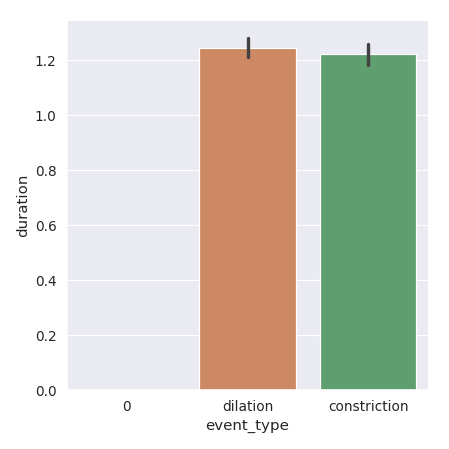

In [529]:
sns.catplot(kind="",x="event_type",y = "duration", data = df_merge[df_merge.event_type !=''])

In [514]:
df_merge.loc[df_merge.duration == 12]= 0 

In [502]:
#df_merge["cont_rate"] = df_merge["duration"].fillna(0).rolling(window=7).mean()
df_merge["cont_rate"] = df_merge["duration"].fillna(0).ewm(span=7).mean()

<IPython.core.display.Javascript object>


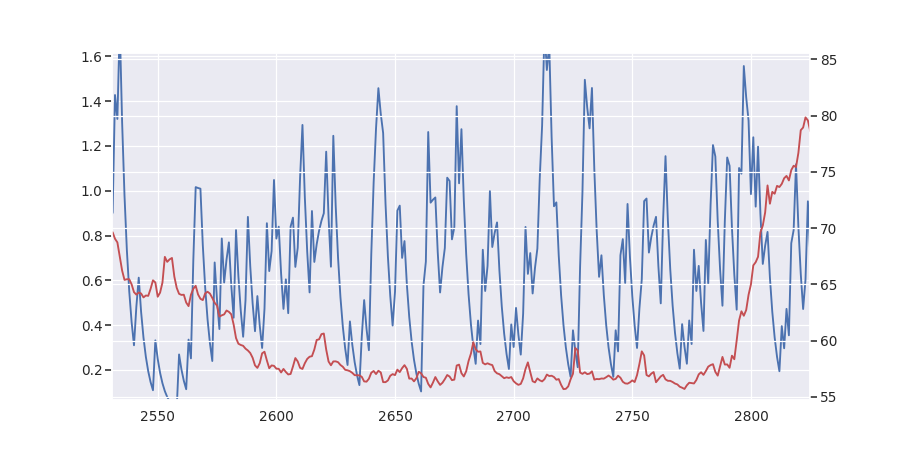

In [503]:
%matplotlib notebook
sns.set()
plt.figure(figsize=(10,5))
sns.lineplot(data=df_merge.cont_rate)
ax2 = plt.twinx()
sns.lineplot(data=rs_dvert,color='r',ax=ax2)
#sns.lineplot(data=velo,color='g',ax=ax2)

<IPython.core.display.Javascript object>


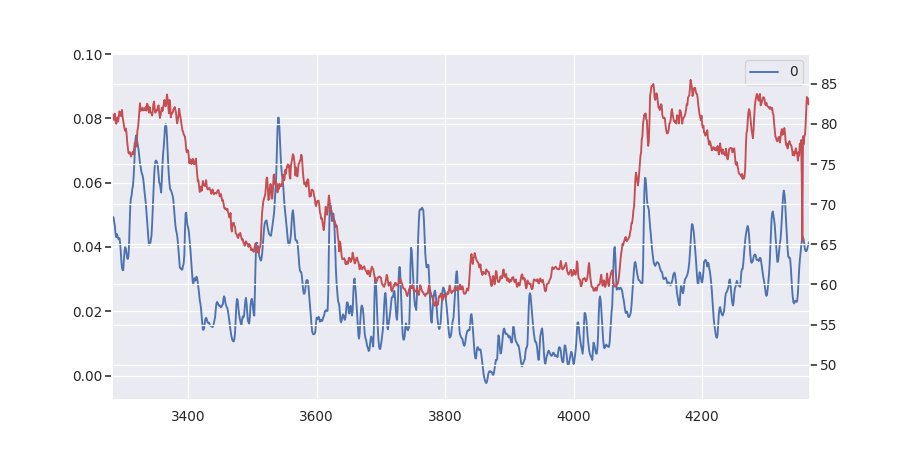

In [509]:
%matplotlib notebook
sns.set()
plt.figure(figsize=(10,5))
sns.lineplot(data=mean_ca)
ax2 = plt.twinx()
sns.lineplot(data=rs_dvert,color='r',ax=ax2)
#sns.lineplot(data=velo,color='g',ax=ax2)

<IPython.core.display.Javascript object>


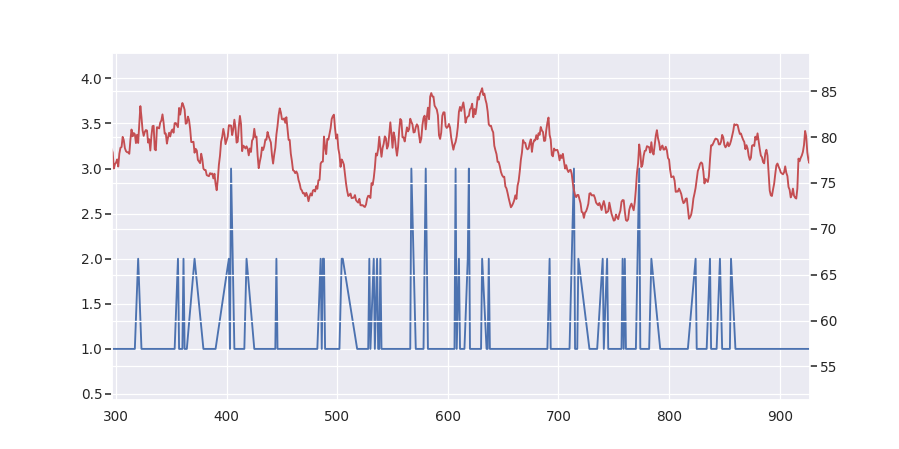

In [515]:
%matplotlib notebook
sns.set()
plt.figure(figsize=(10,5))
sns.lineplot(data=df_merge.duration)
ax2 = plt.twinx()
sns.lineplot(data=rs_dvert,color='r',ax=ax2)
#sns.lineplot(data=velo,color='g',ax=ax2)

In [ ]:
%matplotlib notebook
sns.set()
plt.figure(figsize=(10,5))
sns.lineplot(data=df_merge.duration)
ax2 = plt.twinx()
sns.lineplot(data=rs_dvert,color='r',ax=ax2)
#sns.lineplot(data=velo,color='g',ax=ax2)

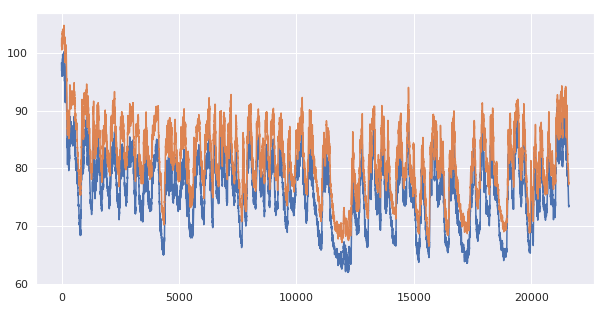

In [225]:
fn='/home/matt/creb/pupil/CREB9/processed/mjd535_20180616163628DeepCut_resnet50_pupilMay11shuffle1_240000.h5'

directory='/home/matt/creb/pupil/CREB9/processed'
path = os.path.join(directory,fn)

dvert, dhorz = pupil_size(path,plot=True)

#pd.DataFrame(np.vstack([dvert,dhorz]).T,columns=["a","b"])

# resample pupil

In [ ]:
# calc behavior frames
recordingDuration=720 #HARD CODED
sampling_interval=1/7.8125
numberBehaviorFrames=int(recordingDuration/ sampling_interval)

# resample pupil data to behavior
rs_dvert = signal.resample(dvert, numberBehaviorFrames)

# load transients data

In [ ]:
trans = expt.transientsData(label='suite2p', roi_filter=None,dataframe=True)
df_c = trans.groupby("start_frame").count().reset_index()
df_c = df_c.filter(["start_frame","duration"])

## check dist

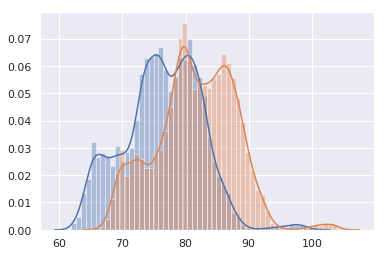

In [226]:
plt.figure()
sns.distplot(dvert)
sns.distplot(dhorz)

# compute pupil dynamics

In [46]:
def calculate_baseline(data,plot=False):
    imgPeriod=1.0/30.0 #hard coded, 30 hz for these images
    t1=int(.1 / imgPeriod) #works well for pupil mean, 30hz
    t2=int(10 / imgPeriod) #works well for pupil mean, 30hz
    
    data2=pd.Series(data)
    data2=rolling_window(data2.T, window=t1, win_type='boxcar',
                    min_periods=t1 / 3, center=True, axis=0).T
    data2=rolling_apply(data2.T, t2, np.nanmin, min_periods=t2 / 3,
                    center=True).T
    baseline=data2.values

    if plot:
        plt.plot(data2)
        plt.plot(baseline)
        plt.show()

    return baseline

def detect_blinks(images):
    mean_int=np.mean(np.mean(images,axis=1),axis=1)
    baseline=calculate_baseline(mean_int)
    corrected_data=mean_int-baseline
    noise=np.std(corrected_data) # valid for low blink number
    blink_ind=np.where(corrected_data > 10*noise)[0] #10 sigma massive event
    
    # add + and - 2 frames to make sure full blink captured (may increase based on dt)
    blink_ind=np.concatenate((blink_ind,blink_ind+2,blink_ind-2))
    blink_ind=list(set(blink_ind))
    
    return blink_ind


In [235]:
# alternate smoothing, likely don't need, since pupil funtion does it?
dvert_sm = smooth(dvert,window_len=15,window= 'flat')
df = pd.DataFrame(dvert_sm,columns=["dvert"])
df["dvert"].interpolate(method='polynomial', order=2,inplace=True)

## example smooth
Mot too much smoothing observed

<IPython.core.display.Javascript object>


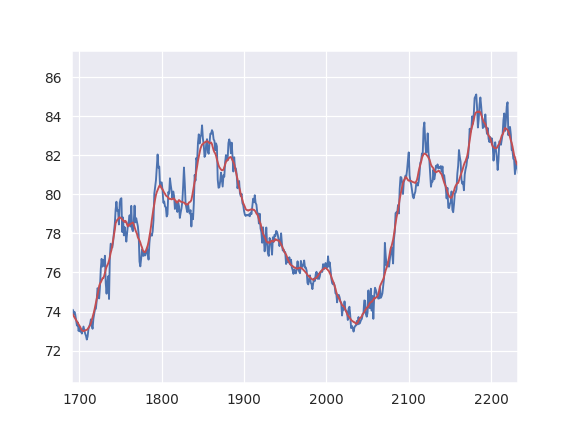

In [237]:
%matplotlib notebook
#butter_lowpass_filter(dvert,10,15)
sm = smooth(dvert,window_len=30,window= 'flat')
plt.plot(dvert,'b')
plt.plot(df.dvert,'r')


## calculate pupil phases

<IPython.core.display.Javascript object>


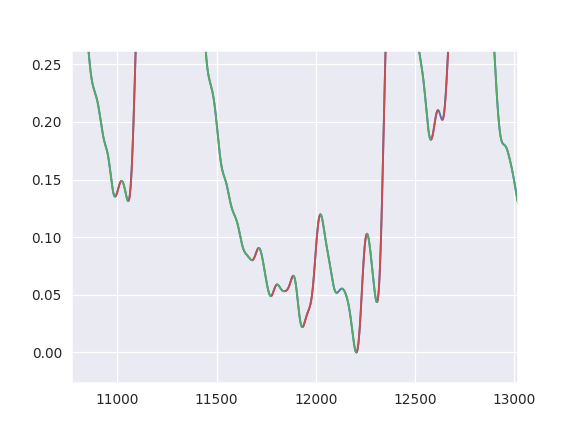

Empty DataFrame
Columns: [start, end, event_type, mean_slope, length]
Index: []

In [442]:
d, df_pupil = pupil.detect_pupil_phases(dvert,seconds=False,plot_phases=True,cutoff_freq = .5)

# sort by length
df_pupil[df_pupil.length < 30]

<IPython.core.display.Javascript object>


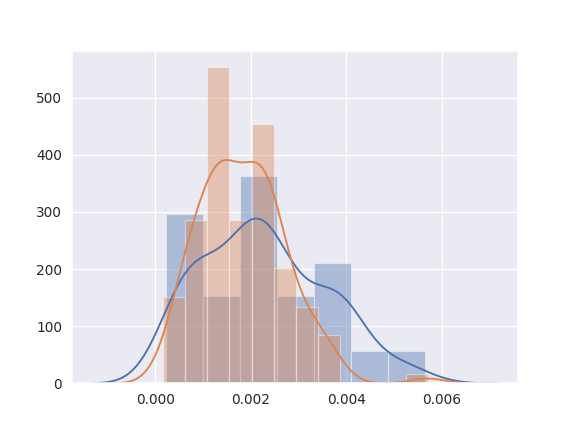

In [240]:
plt.figure()
sns.distplot(d['d_slope'])
sns.distplot(d['c_slope'])

# transients

In [350]:
# resample pupil to beahvior drames
sampling_interval = 30/7.8125
df_pupil["start_rs"] = df_pupil.start.apply(lambda x: int(x/sampling_interval))
df_pupil["end_rs"] = df_pupil.end.apply(lambda x: int(x/sampling_interval))

In [359]:
# make dataframe where full indexes represented
df_pupil_full=pd.DataFrame(np.arange(0,numberBehaviorFrames))
df_pupil_full["event_type"] = ''
for ind,row in df_pupil.iterrows():
    if row.event_type == 'constriction':
        df_pupil_full.loc[row.start_rs:row.end_rs,"event_type"] = "constriction"
    if row.event_type == 'dilation':
        df_pupil_full.loc[row.start_rs:row.end_rs,"event_type"] = "dilation"
        
df_pupil_full.rename(columns={0:'index'},inplace = True)

In [379]:
# merge with imaging DF
df_merge = pd.merge(df_pupil_full,df_c,left_on="index",right_on = "start_frame",how="left")

## plot merge

<IPython.core.display.Javascript object>


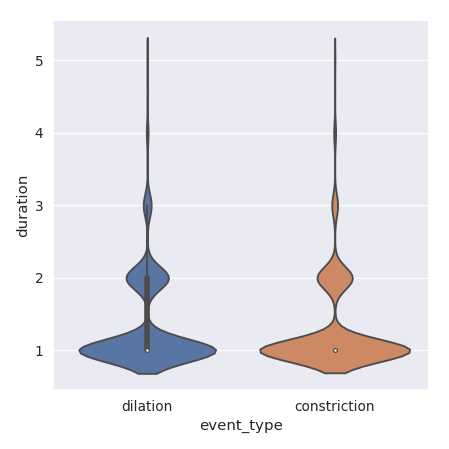

In [383]:
sns.catplot(kind="violin",x="event_type",y = "duration", data = df_merge[df_merge.event_type !=''])

In [395]:
# remove large number from first row
df_merge.loc[df_merge.duration == 21] = 0

<IPython.core.display.Javascript object>


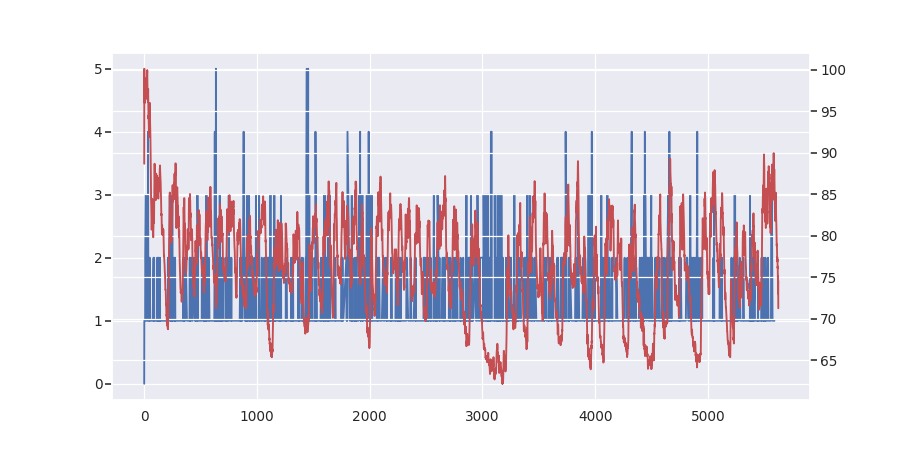

In [441]:
%matplotlib notebook
sns.set()
plt.figure(figsize=(10,5))
sns.lineplot(data=df_merge.duration)
ax2 = plt.twinx()
sns.lineplot(data=rs_dvert,color='r',ax=ax2)
#sns.lineplot(data=velo,color='g',ax=ax2)

<IPython.core.display.Javascript object>


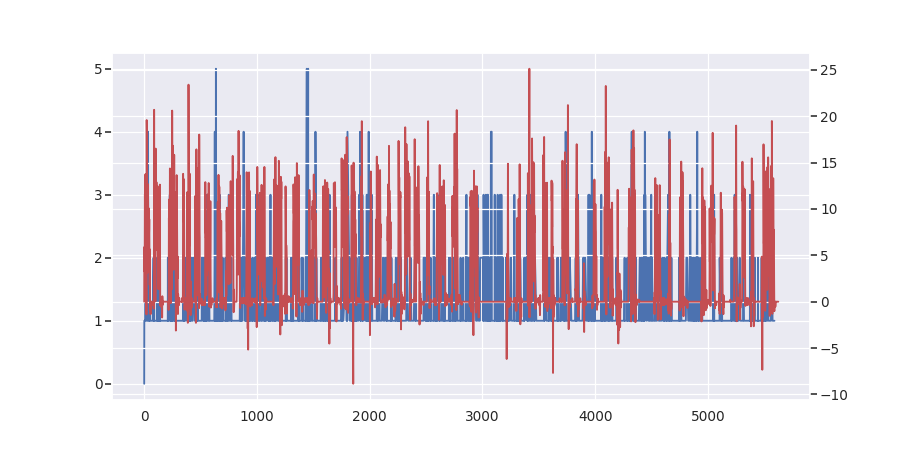

In [398]:
# velocity

sns.set()
plt.figure(figsize=(10,5))
sns.lineplot(data=df_merge.duration)
ax2 = plt.twinx()
sns.lineplot(data=velo,color='r',ax=ax2)

# load expt and expt data

In [220]:


expt=db.createExperiment(tSeries_path='/home/matt/creb/CREB9/mjd535/20180616-RF-MJD4B-SUP-1')



In [28]:
dvert.shape[0]

21600

<IPython.core.display.Javascript object>


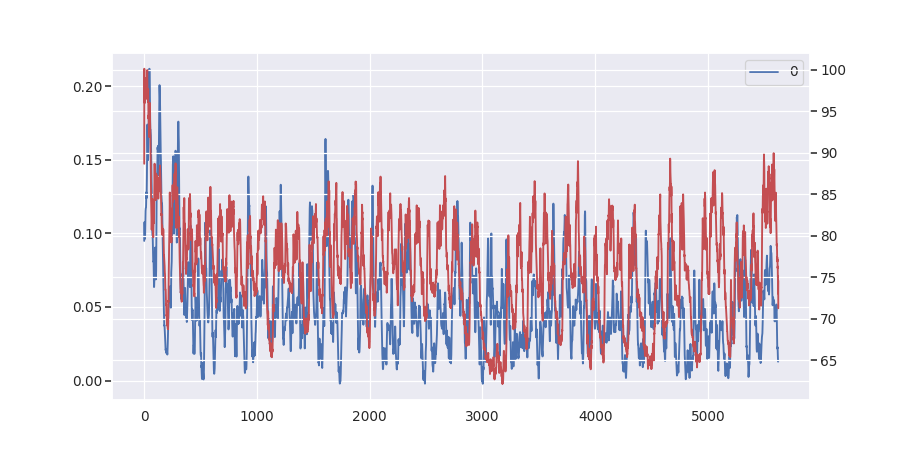

In [241]:
plt.figure(figsize=(10,5))
mean_ca=np.nanmean(expt.imagingData(dFOverF='from_file'),axis=0)
sns.lineplot(data=mean_ca)
ax2 = plt.twinx()
sns.lineplot(data=rs_dvert,color='r',ax=ax2)

## scatter: dfof v pupil

<IPython.core.display.Javascript object>


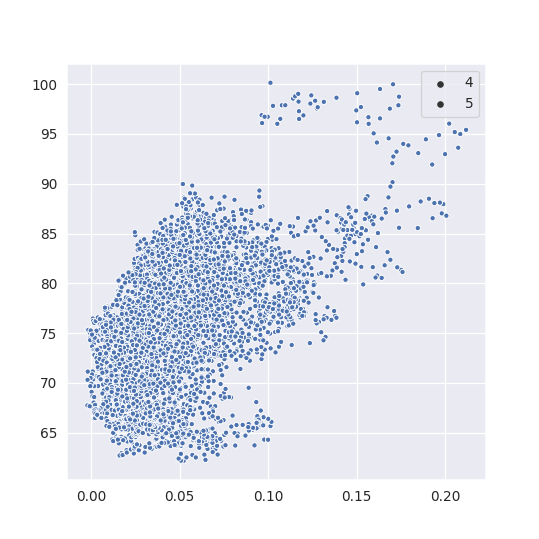

(0.4746232874879847, 5.0223647113e-314)


In [246]:
fig, ax = plt.subplots(figsize=(6,6))
pearsonr(np.squeeze(mean_ca), rs_dvert)
sns.scatterplot(np.squeeze(mean_ca),rs_dvert,size=5)
print(pearsonr(np.squeeze(mean_ca), rs_dvert))

## running and velocity

In [13]:
run=expt.runningIntervals()
velo=expt.velocity()[0]fig, ax = plt.subplots(figsize=(4,4))
pearsonr(velo, rs_dvert)
plt.scatter(velo,rs_dvert)

<IPython.core.display.Javascript object>


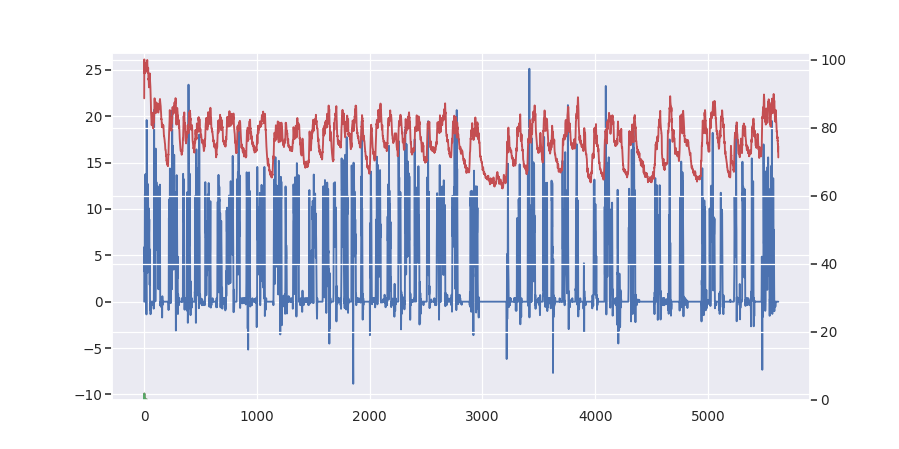

In [247]:
sns.set()
plt.figure(figsize=(10,5))
mean_ca=np.nanmean(expt.imagingData(dFOverF='from_file'),axis=0)
sns.lineplot(data=velo)
ax2 = plt.twinx()
sns.lineplot(data=rs_dvert,color='r',ax=ax2)

<IPython.core.display.Javascript object>


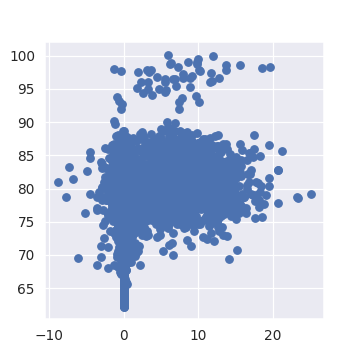

In [248]:
fig, ax = plt.subplots(figsize=(4,4))
pearsonr(velo, rs_dvert)
plt.scatter(velo,rs_dvert)

# Smooth signal

In [60]:
from scipy import signal
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    # Source: https://mal_cutoff = float(cutoff) / nyq_freq
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y


def smooth(x, window_len=10, window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal 
        window_len: the dimension of the smoothing window
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    import numpy as np    
    t = np.linspace(-2,2,0.1)
    x = np.sin(t)+np.random.randn(len(t))*0.1
    y = smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string   
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."

    if window_len < 3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"

    s=np.r_[2*x[0]-x[window_len:1:-1], x, 2*x[-1]-x[-1:-window_len:-1]]
    #print(len(s))
    
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = getattr(np, window)(window_len)
    y = np.convolve(w/w.sum(), s, mode='same')
    return y[window_len-1:-window_len+1]

# extra

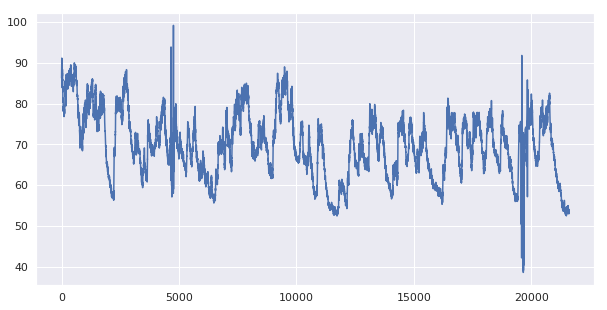

In [40]:
from scipy import stats
dvert_z = np.abs(stats.zscore(dvert))
ind=np.where(dvert_z > 4)[0]
dvert[ind] = np.nan

#smooth
dvert_sm = butter_lowpass_filter(dvert,10,15)

plt.figure(figsize=(10,5))
sns.lineplot(x=np.arange(0,len(dvert)),y=dvert)
#sns.lineplot(x=np.arange(0,len(dvert_sm)),y=dvert_sm)

In [43]:
from scipy import stats
dvert_z = np.abs(stats.zscore(dvert))
ind=np.where(dvert_z > 4)[0]
dvert[ind] = np.nan

#smooth
dvert_sm = butter_lowpass_filter(dvert,10,15)

plt.figure(figsize=(10,5))
sns.lineplot(x=np.arange(0,len(dvert)),y=dvert)
sns.lineplot(x=np.arange(0,len(dvert_sm)),y=dvert_sm)

SyntaxError: non-keyword arg after keyword arg (<ipython-input-43-acf8f7e6dcce>, line 11)

<IPython.core.display.Javascript object>


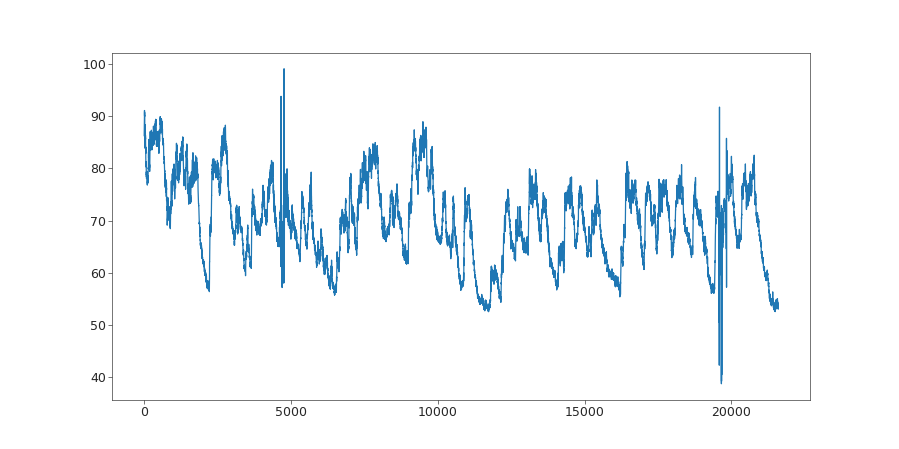

In [7]:
from scipy import stats
dvert_z = np.abs(stats.zscore(dvert))
ind=np.where(dvert_z > 4)[0]
dvert[ind] = np.nan

#smooth
dvert_sm = butter_lowpass_filter(dvert,10,15)

plt.figure(figsize=(10,5))
sns.lineplot(x=np.arange(0,len(dvert)),y=dvert)
#sns.lineplot(x=np.arange(0,len(dvert_sm)),y=dvert_sm)

In [8]:
dvert_sm = butter_lowpass_filter(dvert,2,15)
sns.lineplot(x=np.arange(0,len(dvert_sm)),y=dvert_sm)